Set up environment variable

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

Install dependencies

In [2]:
%pip install Pillow
%pip install PyYAML

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.13.1+cu117 True
gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
import sys, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15054, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15054 (delta 37), reused 61 (delta 35), pack-reused 14975
Receiving objects: 100% (15054/15054), 6.12 MiB | 420.00 KiB/s, done.
Resolving deltas: 100% (10902/10902), done.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import some common libraries
%matplotlib inline
import numpy as np
import cv2
import random
import pandas as pd
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Import omidb
import omidb

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common detectron2 utilities
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode, Boxes, pairwise_iou

Create DETR config

In [5]:
# Don't execute this cell after running the script (not needed for the inference and evaluation)!
!git clone https://github.com/facebookresearch/detr
!python detr/d2/converter.py --source_model https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth --output_model detr/converted_model.pth

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 5.77 MiB/s, done.
Resolving deltas: 100% (122/122), done.
transformer.encoder.layers.0.self_attn.in_proj_weight -> detr.transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias -> detr.transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight -> detr.transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias -> detr.transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight -> detr.transformer.encoder.layers.0.linear1.weight
transformer.encoder.layers.0.linear1.bias -> detr.transformer.encoder.layers.0.linear1.bias
transformer.encoder.layers.0.linear2.weight -> detr.transformer.encoder.layers.0.linear2.weight
transformer.encoder.lay

Register Data

In [8]:
DatasetCatalog.clear()

In [4]:
def get_omidb_dicts(img_dir, csv_dir):
    df = pd.read_csv(csv_dir)
    
    dataset_dicts = []
    for idx, row in df.iterrows():
        record = {}
        filename = os.path.join(img_dir, row["filename"])

        record["file_name"] = filename
        record["image_id"] = idx
        
        if row['side'] == 'R':
            # Bounding box breast area         
            bbox = row["bbox"][12:-1]
            coords1 = bbox.split(',')
            r= np.array([0,0,0,0])
            indx1 = 0
            for c in coords1:
                aux = c.split('=')
                r[indx1]=(int(aux[1]))
                indx1 +=1

            # we can get width and heigth from bbox
            record["height"] = r[3]-r[1]
            record["width"] = r[2]-r[0]
            
            # Bounding box roi  
            bbox_roi = row["bbox_roi"][12:-1]
            coords2 = bbox_roi.split(',')
            s= np.array([0,0,0,0])
            indx2 = 0
            for c in coords2:
                aux = c.split('=')
                s[indx2]=(int(aux[1]))
                indx2 +=1
            bbox_roi = omidb.mark.BoundingBox(s[0]-r[0],s[1]-r[1],s[2]-r[0],s[3]-r[1])
            
        else:
            im = cv2.imread(filename)
            h,w,_ = im.shape
            record["height"] = h
            record["width"] = w

            # Bounding box roi  
            bbox_roi = row["transformed_bbox_roi"][12:-1]
            coords2 = bbox_roi.split(',')
            s= np.array([0,0,0,0])
            indx2 = 0
            for c in coords2:
                aux = c.split('=')
                float_value = round(float(aux[1]), 0)
                s[indx2]=(int(float_value))
                indx2 +=1
            bbox_roi = omidb.mark.BoundingBox(s[0],s[1],s[2],s[3])

        px = [bbox_roi.x1, bbox_roi.x2, bbox_roi.x2, bbox_roi.x1]
        py = [bbox_roi.y1, bbox_roi.y1, bbox_roi.y2, bbox_roi.y2]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]
        objs = []
        obj =  {
                "bbox": [bbox_roi.x1 , bbox_roi.y1, bbox_roi.x2, bbox_roi.y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("omidb_train", lambda: get_omidb_dicts("/home/habtamu/Mammogram_Registration_Four_Resolution/stacked_without_difference_image","/home/habtamu/Mammogram_Registration_Four_Resolution/transformed_lesion_training_set.csv"))
MetadataCatalog.get("omidb_train").set(thing_classes=["lesion"])

DatasetCatalog.register("omidb_val", lambda: get_omidb_dicts("/home/habtamu/Mammogram_Registration_Four_Resolution/stacked_without_difference_image","/home/habtamu/Mammogram_Registration_Four_Resolution/transformed_lesion_validation_set.csv"))
MetadataCatalog.get("omidb_val").set(thing_classes=["lesion"])

namespace(name='omidb_val', thing_classes=['lesion'])

Training and val set dictionaries

In [5]:
train_metadata = MetadataCatalog.get("omidb_train")
train_dictionary = DatasetCatalog.get("omidb_train")

val_metadata = MetadataCatalog.get("omidb_val")
val_dictionary = DatasetCatalog.get("omidb_val")

In [6]:
len(val_dictionary)

658

Visualize some training images and their corresponding bbox

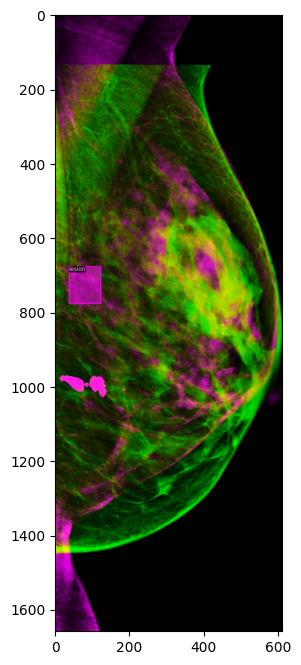

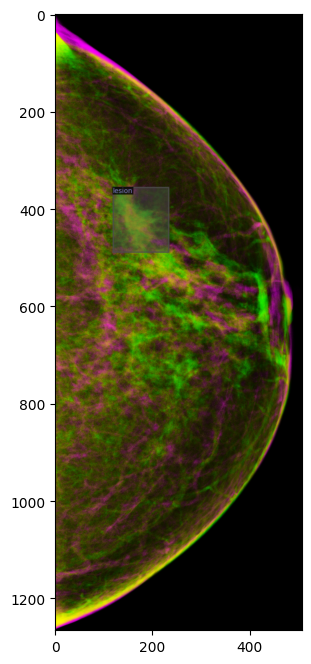

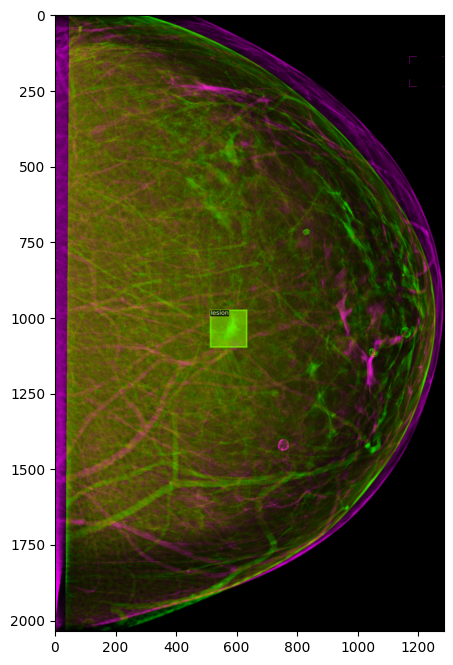

In [9]:
for d in random.sample(train_dictionary, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

Set up the configuration for the omidb dataset

In [ ]:
%cd detr
from d2.detr import add_detr_config
%cd ../
cfg = get_cfg()
add_detr_config(cfg)
cfg.merge_from_file("detr/d2/configs/detr_256_6_6_torchvision.yaml")
cfg.DATASETS.TRAIN = ("omidb_train",)
cfg.DATASETS.TEST = ("omidb_val",)
cfg.OUTPUT_DIR = 'outputs/'
cfg.MODEL.WEIGHTS = "detr/converted_model.pth"
cfg.MODEL.DETR.NUM_CLASSES = 1
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00005
cfg.SOLVER.MAX_ITER = 900000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

Train the model by using the trainer provided by DETR

In [ ]:
# from detectron2.engine import DefaultTrainer
%cd detr
from d2.train_net import Trainer
%cd ../
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Launch Tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /home/habtamu/DETR_from_Detectron2/outputs/

Save config to file

In [19]:
config_file = 'config_final_900k.yaml'
with open("/home/habtamu/DETR_Multi_View/outputs/"+config_file, "w") as f:
    f.write(cfg.dump())

Evaluate performance using AP metric implemented in COCO API.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("omidb_train", cfg, False, output_dir="./coco_eval_output/")
val_loader = build_detection_test_loader(cfg, "omidb_train")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

Inference and evaluation using the trained model

In [10]:
# A function to filter predictions having confidence probability above the threshold
def filter_predictions_from_outputs(outputs,
                                    threshold=0.25,
                                    verbose=True):

  predictions = outputs["instances"].to("cpu")

  if verbose:
    print(list(predictions.get_fields()))

  indices = [i
            for (i, s) in enumerate(predictions.scores)
            if s >= threshold
            ]

  filtered_predictions = predictions[indices]

  return filtered_predictions

In [6]:
%cd detr
from d2.detr import add_detr_config
%cd ../
cfg = get_cfg()
add_detr_config(cfg)
cfg.merge_from_file("/home/habtamu/DETR_Multiview_without_Diff/outputs/config_final_46k_25e-05_256.yaml")
cfg.DATASETS.TRAIN = ("omidb_train",)
cfg.DATASETS.TEST = ("omidb_val",)
cfg.OUTPUT_DIR = '/home/habtamu/DETR_Multiview_without_Diff/outputs/'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best_39k.pth") 
cfg.MODEL.DETR.NUM_CLASSES = 1
predictor = DefaultPredictor(cfg)

/home/habtamu/DETR_Multiview_without_Diff/detr
/home/habtamu/DETR_Multiview_without_Diff
[06/08 17:59:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/habtamu/DETR_Multiview_without_Diff/outputs/model_best_39k.pth ...


Predictions without setting a threshold (it may crash while plotting)

In [ ]:
for d in random.sample(val_dictionary, 3):  
  im = cv2.imread(d["file_name"])
  visualizer1 = Visualizer(im[:, :, ::-1],
                metadata=val_metadata, 
                scale=0.5
                 )
  visualizer2 = Visualizer(im[:, :, ::-1],
                metadata=val_metadata, 
                scale=0.5
                 )

  # Ground-truth
  vis = visualizer1.draw_dataset_dict(d)

  # Prediction
  outputs = predictor(im)
  out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))

  # Create a figure with two subplots
  fig, axes = plt.subplots(nrows=1, ncols=2)

  # Plot the images on each subplot
  axes[0].imshow(vis.get_image()[:, :, ::-1])
  axes[1].imshow(out.get_image()[:, :, ::-1])

  # Set the titles for each subplot
  axes[0].set_title('Ground-truth')
  axes[1].set_title('Prediction')

  # Display the plot
  plt.show()

Predictions with a threshold of 0.01

In [ ]:
dataset_name = cfg.DATASETS.TRAIN[0]
custom_metadata = MetadataCatalog.get(dataset_name)
threshold = 0.01

dataset_dicts = DatasetCatalog.get("omidb_val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])  
    visualizer1 = Visualizer(im[:, :, ::-1],
                   metadata=custom_metadata, 
                   scale=0.5, 
    )
    visualizer2 = Visualizer(im[:, :, ::-1],
                   metadata=custom_metadata, 
                   scale=0.5, 
    )
    
    # Ground-truth
    vis = visualizer1.draw_dataset_dict(d)

    # Prediction
    outputs = predictor(im)
    filtered_predictions = filter_predictions_from_outputs(outputs,
                                                           threshold=threshold)
    out = visualizer2.draw_instance_predictions(filtered_predictions)

    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2)

    # Plot the images on each subplot
    axes[0].imshow(vis.get_image()[:, :, ::-1])
    axes[1].imshow(out.get_image()[:, :, ::-1])

    # Set the titles for each subplot
    axes[0].set_title('Ground-truth')
    axes[1].set_title('Prediction')

    # Display the plot
    plt.show()

Predictions with a threshold of 0.25

['pred_boxes', 'scores', 'pred_classes']


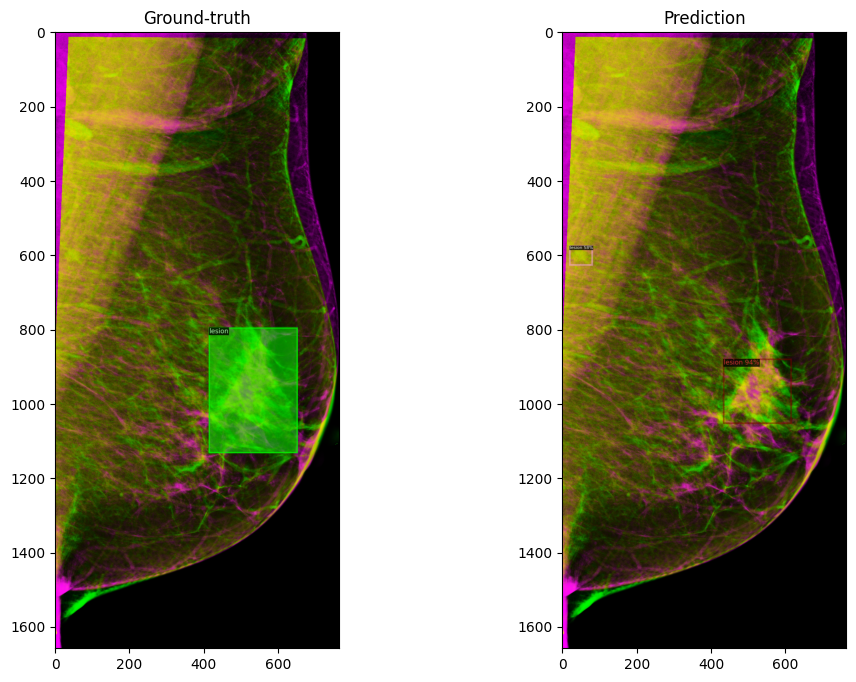

['pred_boxes', 'scores', 'pred_classes']


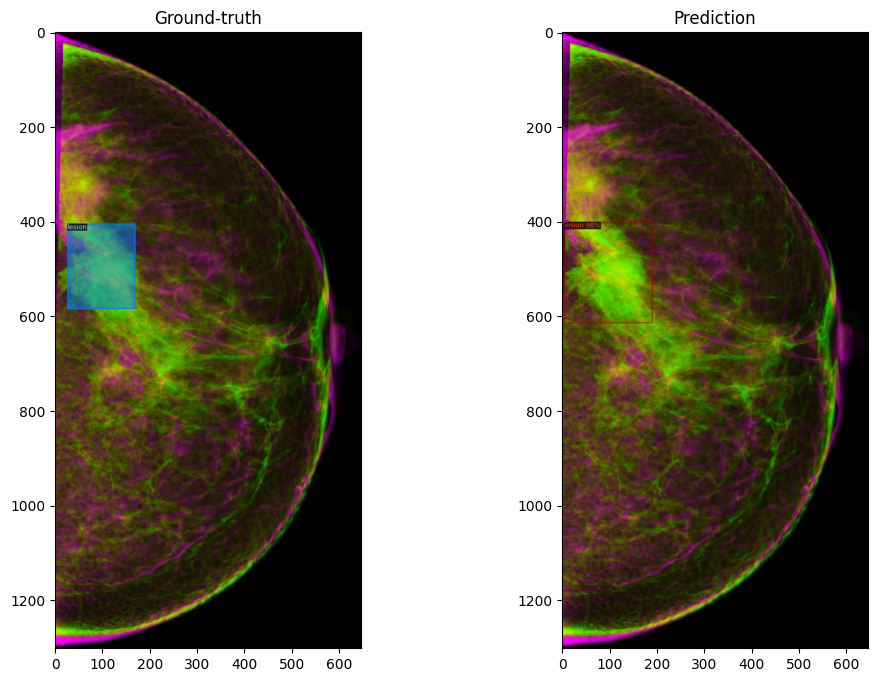

['pred_boxes', 'scores', 'pred_classes']


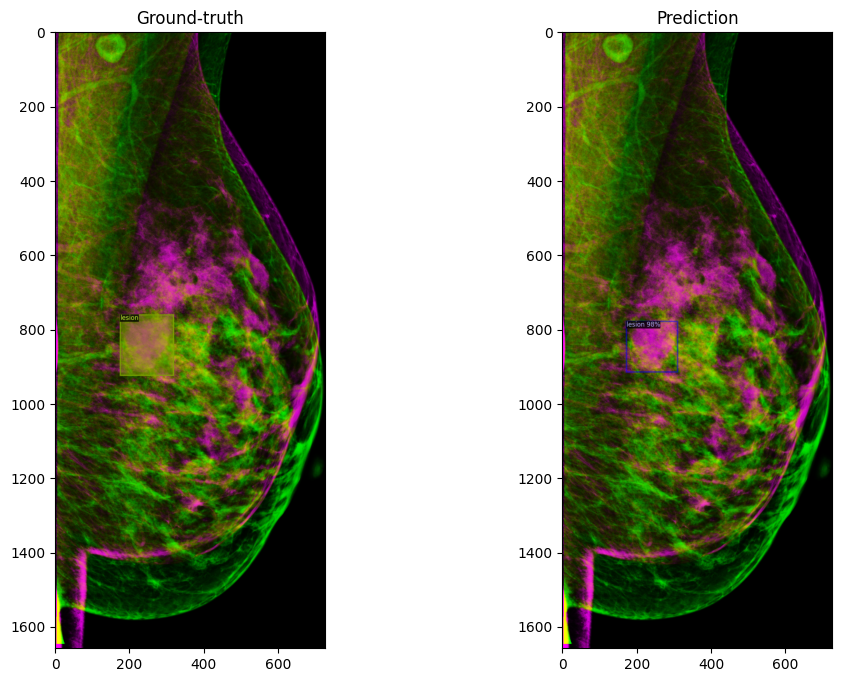

In [15]:
dataset_name = cfg.DATASETS.TRAIN[0]
custom_metadata = MetadataCatalog.get(dataset_name)
threshold = 0.25

dataset_dicts = DatasetCatalog.get("omidb_val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])  
    visualizer1 = Visualizer(im[:, :, ::-1],
                   metadata=custom_metadata, 
                   scale=0.5, 
    )
    visualizer2 = Visualizer(im[:, :, ::-1],
                   metadata=custom_metadata, 
                   scale=0.5, 
    )
    
    # Ground-truth
    vis = visualizer1.draw_dataset_dict(d)

    # Prediction
    outputs = predictor(im)
    filtered_predictions = filter_predictions_from_outputs(outputs,
                                                           threshold=threshold)
    out = visualizer2.draw_instance_predictions(filtered_predictions)

    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2)

    # Plot the images on each subplot
    axes[0].imshow(vis.get_image()[:, :, ::-1])
    axes[1].imshow(out.get_image()[:, :, ::-1])

    # Set the titles for each subplot
    axes[0].set_title('Ground-truth')
    axes[1].set_title('Prediction')

    # Display the plot
    plt.show()

A function to display results

In [16]:
def run_worflow(my_image,
                my_model,
                threshold = 0.25,
                verbose=False):  
  outputs = my_model(my_image)

  filtered_predictions = filter_predictions_from_outputs(outputs,
                                                         threshold=threshold,
                                                         verbose=verbose)

  v = Visualizer(my_image[:, :, ::-1], 
                 custom_metadata,
                 scale=1.2)
  out = v.draw_instance_predictions(filtered_predictions)
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show()

  return

With a training image

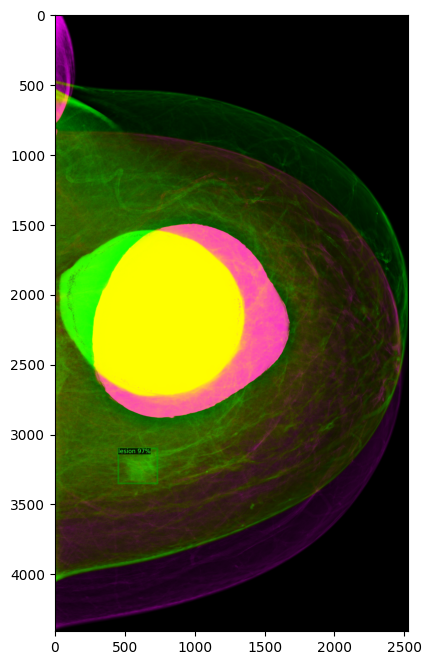

In [18]:
img_name = '/home/habtamu/Mammogram_Registration_Four_Resolution/stacked_images/demd7418_9971_1.2.826.0.1.3680043.9.3218.1.1.3370786.8916.1512165599585.4141.0_CC.png'
im = cv2.imread(img_name)

threshold = 0.25

run_worflow(im,
            predictor,
            threshold = threshold)

With a validation image

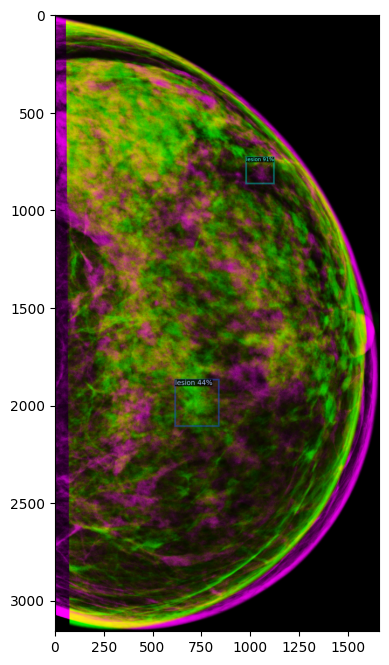

In [20]:
img_name = '/home/habtamu/Mammogram_Registration_Four_Resolution/stacked_images/demd5550_9986_1.2.826.0.1.3680043.9.3218.1.1.2984797.8432.1512127000746.5854.0_CC.png'
im = cv2.imread(img_name)

threshold = 0.25

run_worflow(im,
            predictor,
            threshold = threshold)

Custom Evaluation

In [7]:
predictions = []
for d in val_dictionary:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    predictions.append(outputs)

Non-maximum Suppression

In [9]:
def apply_nms(predictions, iou_threshold):
    filtered_predictions = []
    filtered_scores = []
    for k in range(len(predictions)):
        pred_boxes = predictions[k]["instances"].pred_boxes.to("cpu")
        scores = predictions[k]["instances"].scores.to("cpu")
        keep = [True] * len(pred_boxes)
        for i in range(len(pred_boxes)):
            if keep[i]:
                for j in range(i + 1, len(pred_boxes)):
                    if keep[j]:
                        pairwise_IoU = pairwise_iou(pred_boxes[i], pred_boxes[j])
                        iou = pairwise_IoU[0][0].item()
                        if iou >= iou_threshold:
                            keep[j] = False
        filtered_pred_boxes = [pred for pred, keep_pred in zip(pred_boxes, keep) if keep_pred]
        filtered_confidences = [score for score, keep_score in zip(scores, keep) if keep_score]
        if len(pred_boxes) == 0:
            combined_pred_boxes = Boxes(torch.zeros(0, 4))
            combined_scores = torch.zeros(0)
        else:
            combined_pred_boxes = Boxes(torch.stack(filtered_pred_boxes))
            combined_scores = torch.stack(filtered_confidences)
        filtered_predictions.append(combined_pred_boxes)
        filtered_scores.append(combined_scores)
    return filtered_predictions, filtered_scores

In [10]:
filtered_predictions, filtered_scores = apply_nms(predictions, iou_threshold=0.05)

TPR Vs IoU

In [8]:
post_processed = False

In [20]:
tp = np.zeros(99)
fp = np.zeros(99)
fn = np.zeros(99)
tpr = []

#thresholds = np.linspace(0, 1, 100)
# I divide values in the range [0,1] into 100 IOU thresholds
# But there is no true positive at IOU of zero
# Therefore, I started from 0.01010101 and divide values in the range [0.01010101,1] into 99 IOU thresholds
thresholds = np.linspace(0.01010101, 1, 99)
for i in range(len(val_dictionary)):
    bbox_coords = val_dictionary[i]['annotations'][0]['bbox']
    groundtruth_bbox = Boxes(torch.tensor([bbox_coords], dtype=torch.float32))
    if post_processed:
        pred_boxes = filtered_predictions[i]
    else:
        pred_boxes = predictions[i]["instances"].pred_boxes.to("cpu")
    IOUs = pairwise_iou(groundtruth_bbox, pred_boxes)
    
    # False positives array of size (99, number of predicted boxes)
    # If the predicted box is false positive at threshold k, 
    # the value of false_positives_arr[k, pred_box_index] will be 1.
    # Otherwise, it is zero.
    false_positives_arr = np.zeros((99, len(pred_boxes)))
    true_positives_arr = np.zeros((99, len(pred_boxes)))
    for j in range(len(pred_boxes)):
        iou = IOUs[0,j].item()
        k = 0
        for threshold in thresholds:
            if iou >= threshold:
                tp[k] = tp[k]+1
                true_positives_arr[k][j] = 1
            else:
                fp[k] = fp[k]+1
                false_positives_arr[k][j] = 1
            k = k + 1
    t = 0
    for thresh in thresholds:
        num_ones = np.sum(true_positives_arr[t] == 1)
        # When multiple boxes detect the same object, the box with the highest IOU is considered TP, while the remaining boxes are considered FP.
        if num_ones > 1:
            false_pos = num_ones - 1
            tp[t] = tp[t] - false_pos
            fp[t] = fp[t] + false_pos

        if len(pred_boxes)==0: # If there is no predicted box
            fn[t] = fn[t]+1
        elif len(pred_boxes)==1: # If there is only one predicted box
            if false_positives_arr[t][0] == 1:
                fn[t] = fn[t]+1
        else: # If there are many predictions
            # If all values in false_positives_arr are 1
            if np.all(false_positives_arr[t] == false_positives_arr[t][0]) and false_positives_arr[t][0] == 1: 
                fn[t] = fn[t]+1
        t = t + 1

for l in range(99): 
    tpr.append(tp[l] / (tp[l] + fn[l])) 

TPR at the IoU threshold of 0.1

In [21]:
# Find index of IOU value closest to 0.1
iou_index = np.abs(thresholds - 0.1).argmin()

# Get corresponding TPR value
tpr_at_01_iou = tpr[iou_index]

print("TPR value for IoU of 0.1 is:", tpr_at_01_iou)

TPR value for IoU of 0.1 is: 0.9924012158054711


TPR-IoU Curve

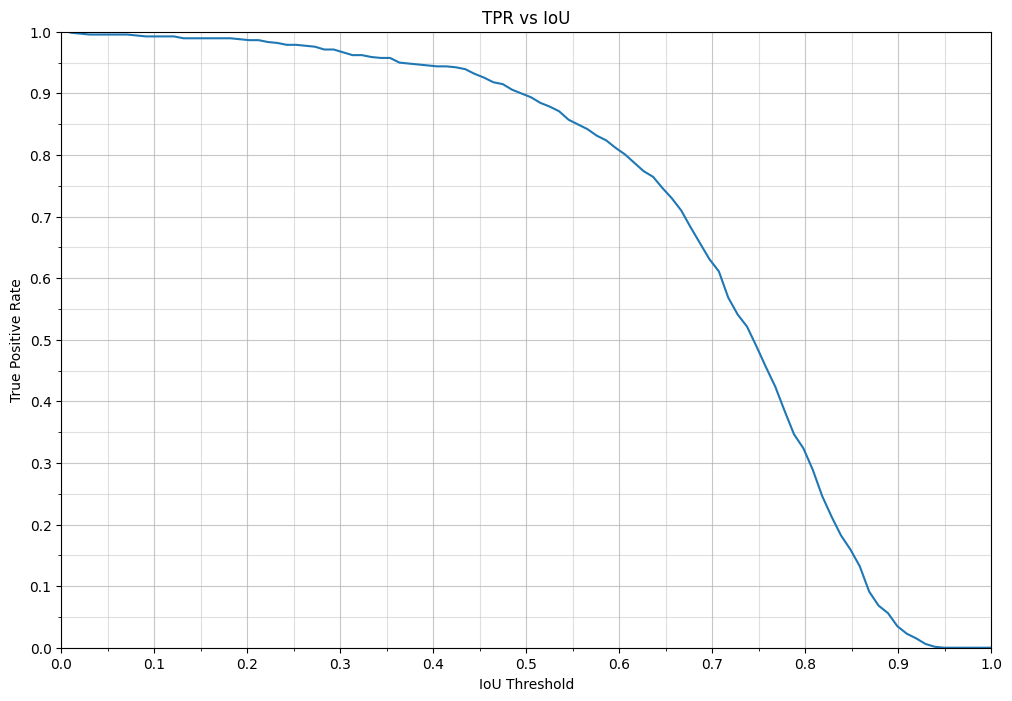

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.grid(which='both')
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.7)

plt.plot(thresholds, tpr)
plt.xlabel("IoU Threshold")
plt.ylabel("True Positive Rate")
plt.title("TPR vs IoU")
plt.show()

TPR vs FPpI

In [27]:
tp = np.zeros(100)
fp = np.zeros(100)
fn = np.zeros(100)
tpr = []
FPpI = []

#confidence_scores = np.linspace(0.01, 1, 100)
confidence_scores = np.linspace(0, 1, 100)
IoU_thresh = 0.1
for i in range(len(val_dictionary)):
    bbox_coords = val_dictionary[i]['annotations'][0]['bbox']
    groundtruth_bbox = Boxes(torch.tensor([bbox_coords], dtype=torch.float32))
    if post_processed:
        pred_boxes = filtered_predictions[i]
        scores = filtered_scores[i]
    else:
        pred_boxes = predictions[i]["instances"].pred_boxes.to("cpu")
        scores = predictions[i]["instances"].scores.to("cpu")
    IOUs = pairwise_iou(groundtruth_bbox, pred_boxes)

    false_positives_arr = np.zeros((100, len(pred_boxes)))
    true_positives_arr = np.zeros((100, len(pred_boxes)))
    for j in range(len(pred_boxes)):
        iou = IOUs[0,j].item()
        score = scores[j].item()
        k = 0
        for conf_score in confidence_scores:
            if score >= conf_score:
                if iou >= IoU_thresh:
                    tp[k] = tp[k]+1
                    true_positives_arr[k][j] = 1
                else:
                    fp[k] = fp[k]+1
                    false_positives_arr[k][j] = 1
            k = k + 1
    s = 0
    for score_thresh in confidence_scores:
        num_ones = np.sum(true_positives_arr[s] == 1)
        # When multiple boxes detect the same object, the box with the highest IOU is considered TP, while the remaining boxes are considered FP.
        if num_ones > 1:
            false_pos = num_ones - 1
            tp[s] = tp[s] - false_pos
            fp[s] = fp[s] + false_pos
        
        if len(pred_boxes)==0: # If there is no predicted box
            fn[s] = fn[s]+1
        elif len(pred_boxes)==1: # If there is only one predicted box
            if false_positives_arr[s][0] == 1:
                fn[s] = fn[s]+1
        else: # If there are many predictions
            # If all values in false_positives_arr are 1
            if np.all(false_positives_arr[s] == false_positives_arr[s][0]) and false_positives_arr[s][0] == 1:
                fn[s] = fn[s]+1
        s = s + 1
for l in range(100): 
    if tp[l] == 0 and fn[l] == 0: # To avoid zero division problem
        tpr.append(0)
    else:
        tpr.append(tp[l] / (658)) 
    FPpI.append(fp[l]/len(val_dictionary))

TPR at 0.75, 0.8, and 0.85 FPpI

In [32]:
FPpI_np = np.array(FPpI)
tpr_np = np.array(tpr)

def compute_tpr_at_target_FPpI(target):

    # Find the index of the element closest to the target
    index = np.abs(FPpI_np - target).argmin()

    # Check if the value at the returned index is already equal to the target
    if FPpI_np[index] == target:
        return tpr[index]
    
    else:
        # Determine the closest values based on the index
        if FPpI_np[index] < target:
            lower_index = index
            upper_index = index+1

        else:
            lower_index = index-1
            upper_index = index

        # Perform linear interpolation
        x1 = FPpI_np[lower_index]
        x2 = FPpI_np[upper_index]
        y1 = tpr[lower_index]
        y2 = tpr[upper_index]
        slope = (y2 - y1) / (x2 - x1)
        y = y1 + slope * (target - x1)
        return y
    
tpr_at_075_FPpI = compute_tpr_at_target_FPpI(0.75)
tpr_at_08_FPpI = compute_tpr_at_target_FPpI(0.8)
tpr_at_085_FPpI = compute_tpr_at_target_FPpI(0.85)

print("TPR value for FPpI of 0.75 is:", tpr_at_075_FPpI)
print("TPR value for FPpI of 0.8 is:", tpr_at_08_FPpI)
print("TPR value for FPpI of 0.85 is:", tpr_at_085_FPpI)

TPR value for FPpI of 0.75 is: 0.8274955436720143
TPR value for FPpI of 0.8 is: 0.8308143939393939
TPR value for FPpI of 0.85 is: 0.8319276094276093


The FROC

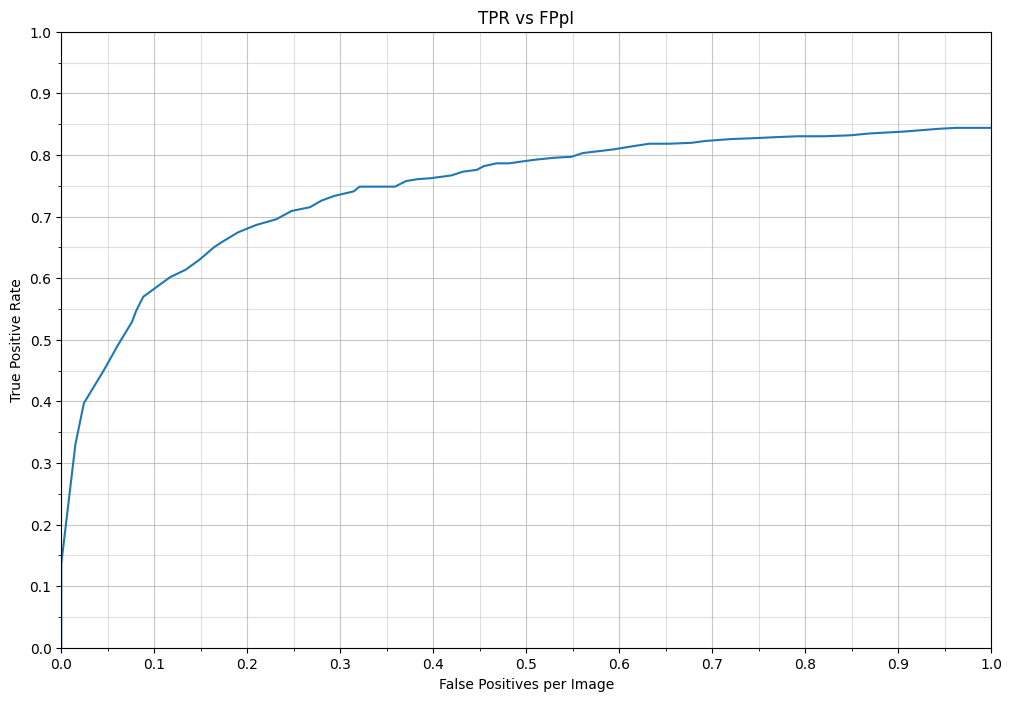

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.grid(which='both')
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.7)

plt.plot(FPpI, tpr)
plt.xlabel("False Positives per Image")
plt.ylabel("True Positive Rate")
plt.title("TPR vs FPpI")
plt.show()

Area Under the FROC

In [33]:
# Reverse order from descending to ascending
tpr_reversed = np.flip(tpr_np)
FPpI_reversed = np.flip(FPpI_np)

def compute_auc():

    # Find the index of the element closest to 1.0
    index = np.abs(FPpI_reversed - 1.0).argmin()

    # Check if the value at the returned index is already equal to 1.0
    if FPpI_reversed[index] == 1.0:
        # Select portion of TPR and FPpI
        tpr_portion = tpr_reversed[:index+1]
        FPpI_portion = FPpI_reversed[:index+1]
    
    else:
        # Determine the closest values based on the index
        if FPpI_reversed[index] < 1.0:
            lower_index = index
            upper_index = index+1

        else:
            lower_index = index-1
            upper_index = index

        # Perform linear interpolation
        x1 = FPpI_reversed[lower_index]
        x2 = FPpI_reversed[upper_index]
        y1 = tpr_reversed[lower_index]
        y2 = tpr_reversed[upper_index]
        slope = (y2 - y1) / (x2 - x1)
        y = y1 + slope * (1.0 - x1)
        tpr_portion = tpr_reversed[:lower_index+1]
        FPpI_portion = FPpI_reversed[:lower_index+1]

        # Adding y to the end of the tpr_portion array
        tpr_portion = np.append(tpr_portion, y)
        FPpI_portion = np.append(FPpI_portion, 1.0)
        froc_auc = metrics.auc(FPpI_portion, tpr_portion)
        return froc_auc
    
print("Area under the FROC:", compute_auc())

Area under the FROC: 0.7433073132541218
